In [311]:
%matplotlib inline
# Common Imports
import numpy as np
#Pandas for creating dataframes
import pandas as pd
#Sklearn
from sklearn import preprocessing
#K-means clustering algo
from sklearn.cluster import KMeans
#OS moduled for file oprations
import os
#CSV module
import csv
#Plotting
import matplotlib.pyplot as plt
import shutil
import glob

In [673]:
#Base Folder Paths
base_folder_name = 'converted'
test_folder_name = 'test3'
base_path = os.path.join(base_folder_name, test_folder_name)
#Normal Sample and cluster paths
sample_dir_name = 'samp'
sample_path = os.path.join(base_path, sample_dir_name)
#If sample folder exist
if os.path.isdir(sample_path):
    #Test and Train data Folders
    sample_train_path = os.path.join(base_path, sample_dir_name+'_train')
    os.makedirs(sample_train_path, exist_ok=True)
    sample_test_path = os.path.join(base_path, sample_dir_name+'_test')
    os.makedirs(sample_test_path, exist_ok=True)
    #Clustering folders
    cluster_train_path = os.path.join(sample_train_path, 'cluster')
    os.makedirs(cluster_train_path, exist_ok=True)
    cluster_test_path = os.path.join(sample_test_path, 'cluster')
    os.makedirs(cluster_test_path, exist_ok=True)
#Defining features
features = [1, 6, 17] #(ICMP:1, TCP:6, UDP:17)    

In [638]:
def filter_ip(df, ip_addr):
    with open(os.path.join(base_path,"filtered_ip_feture_vector"), "a+") as f:
        df.loc[ip_addr].to_csv(f, header=False)
    df = df.drop([ip_addr])
    return df    

In [743]:
def get_feature_dataframe(sample_file, features):
        df = pd.read_csv(sample_file, index_col=0)
        #Filter Columns
        df = df[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
        #Remove null destinations
        df = df[df['ip.dst'].notnull()]
        #Rename Columns
        df.columns = ['ip', 'protocol', 'time_stamp', 'sample']
        #Get count for each ip
        df = df.groupby(['ip', 'protocol']).size().unstack().fillna(0).astype(int)
        #Drop row for given IP
        #df = filter_ip(df, '147.32.84.165')        
        if(set(df.columns) != set(features)):
            non_columns = set(features) - set(df.columns)
            for c in non_columns:
                df.insert(loc=features.index(c), column=c, value=0)
        #Select only required protocols which would be used as features
        df = df[features]
        return df

In [744]:
filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
df = get_feature_dataframe(filenames[0], features)

In [676]:
df.head()

protocol,1,6,17
ip,,,
147.32.80.9,0,0,14
147.32.84.255,0,0,50
195.88.191.59,0,2,0
224.0.0.22,0,0,0
239.255.255.250,0,0,6


In [718]:
#Merge sample files to create bigger sameple
def merge_files(files, merge_count, features):
    if len(files) < merge_count:
        print('Too few file to merge')
        return
    dfs = []
    count = 0
    for file in files:
        if count == 0:
            df = get_feature_dataframe(file, features)
            count += 1
        else:
            temp_df = get_feature_dataframe(file, features)
            df = df.append(temp_df)
            count += 1
        if count == merge_count:
            df = df.groupby(df.index).sum()
            dfs.append(df)
            count = 0
    return dfs

In [719]:
def create_train_test(sample_path, features):
    train_dfs = []; test_dfs = []
    filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
    file_count = len(filenames)
    #Split train and test Train size 80% of data and 20% (1/5 th) is test
    reminder = file_count%5
    #Number of files to be combined to form one train/test data
    merge_count = int((file_count - reminder) / 5)
    
    train_files = filenames[:merge_count*4]
    test_files = filenames[merge_count*4:]
    
    train_dfs = merge_files(train_files, merge_count, features)
    test_dfs = merge_files(test_files, merge_count, features)
    return train_dfs, test_dfs, merge_count

In [720]:
train_dfs, test_dfs, merge_count = create_train_test(sample_path, features)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [680]:
np.savetxt(os.path.join(base_path, 'merge_count'), np.asarray(merge_count).reshape(1,), fmt='%d')

In [681]:
#Write train and test data to file
train_files = []
for i, df in enumerate(train_dfs, 1):
    train_file = os.path.join(sample_train_path,str(i))
    df.to_csv(train_file)
    train_files.append(train_file)
test_files = []    
for i, df in enumerate(test_dfs, 1):
    test_file = os.path.join(sample_test_path,str(i))
    df.to_csv(test_file)
    test_files.append(test_file)

In [682]:
from sklearn.cluster import KMeans
#Find optimal number of clusters for k-means clustering using elbow method.
def elbow_method(X_trans):
    elbow_count = 0
    range_val = 10
    nc = range(1, range_val)
    kmeans = [KMeans(n_clusters=i) for i in nc]
    score = [kmeans[i].fit(X_trans).score(X_trans) for i in range(len(kmeans))]
    total_diff = abs(score[0] - score[len(score) -1])
    for i in range(range_val - 2):
        percent_diff = abs(score[i] - score[i+1])/total_diff
        if percent_diff < 0.01:
            opt_clust_count = i
            break
#     plt.plot(nc,score)
#     plt.xlabel('Number of Clusters')
#     plt.ylabel('Score')
#     plt.title('Elbow Curve')
#     plt.show()
    return opt_clust_count

In [683]:
#Apply elbow method on all the samples and get their mean
def get_optimal_cluster_count(df_list):
    elbow_vals = []
    for df in df_list:
        X = df.values
        #Create scaling
        scaler = preprocessing.StandardScaler().fit(X)
        #Transform Traning data
        X_trans = scaler.transform(X)
        elbow = elbow_method(X_trans)
        elbow_vals.append(elbow)
    return int(np.floor(np.mean(elbow_vals)))

In [684]:
cluster_count = get_optimal_cluster_count(train_dfs)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [685]:
cluster_count

5

In [686]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
def PCA_component_analysis(X_std):
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    # PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
    plt.figure(figsize=(10, 5))
    plt.bar(range(9), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(9), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()

In [687]:
def get_kmeans_centroid(feature_df, cluster_count):
    """ 
    X: feature vector 
    cluster_count: Number of clusters to be used for k-means
    """
    df_centroid = {}
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(X_trans)
    #Insert cluster center to its corrosposnding dataframe each dataframe.
    #Dataframe 0 contain all the clusters centers associated with 0th cluster
    first = True
    for i in range(kmeans.cluster_centers_.shape[0]):
        s = pd.Series(kmeans.cluster_centers_[i], index=feature_df.columns)
        if(first):
            df_centroid = pd.DataFrame(columns=feature_df.columns)
            first = False
        df_centroid = df_centroid.append(s,ignore_index=True)
    return df_centroid

In [688]:
#Find the median of all the centroid which will be better estimate of the centroid for all future k-means clustering
def kmeans_common_create_centroids(sample_frames, features, cluster_count, centroid_filename, features_filename):
    """
    sample_frames: list of feature vector datafames
    centroid_filename: File in which centroid has to be stored for future analyasis
    features_filename: File in which feature list will be stored
    """
    df_concat = pd.DataFrame(columns=features)
    for df in sample_frames:
        #Run kmeans and get centroid
        df_centroid = get_kmeans_centroid(df, cluster_count)
        #Create list of centroids
        df_concat = df_concat.append(df_centroid)
    centroids = []
    #Find median for each centroid and store them in file
    for c in range(cluster_count):
        med = np.median(df_concat.loc[c], axis=0) # e.g. df_concat.loc[0] is df of clister 0
        centroids.append(med)
    #Save centroids and features in files for future use
    np.savetxt(os.path.join(base_path, centroid_filename), np.asarray(centroids), delimiter=",")
    np.savetxt(os.path.join(base_path, features_filename), np.asarray(list(features)), delimiter=",")
    return centroids, features

In [689]:
#File to store centroids
centroid_filename = 'centroids.csv'
#File to store feature list
features_filename = 'features.csv'
#Call to find median of centroid
kmeans_common_create_centroids(train_dfs, features, cluster_count, centroid_filename, features_filename)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


([array([-0.01879115, -0.08887731, -0.07154674]),
  array([ 0.        ,  6.20903888, -0.12229021]),
  array([ 0.        , -0.13241162,  8.76916696]),
  array([-0.01879115, -0.11294475,  5.86812101]),
  array([-0.01879115,  2.21751556, -0.0790368 ])],
 [1, 6, 17])

In [738]:
#Get centroids and feature from the files
def read_centroid_features(centroid_filename, features_filename):
    centroids = np.genfromtxt(os.path.join(base_path,centroid_filename), delimiter=',')
    features = np.genfromtxt(os.path.join(base_path,features_filename), delimiter=',')
    features = list(features.astype('int64'))
    return centroids, features        

In [691]:
from sklearn.decomposition import PCA
def draw_clusters(X, centroids, kmeans):
    #Use PCA component analysis for visuals
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
        km = KMeans(n_clusters=len(np.unique(kmeans.labels_)))
        km.fit(reduced_X)
    else:
        reduced_X = X
        km = kmeans
   
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 0].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')   
    #Plot the data points (PCA reduced components)
    plt.plot(reduced_X[:,0],reduced_X[:,1],  'k.', markersize=3)
    # Plot the centroids as a white X
    centroids = km.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title('K-means clustering with (PCA-reduced data)')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [692]:
def kmeans_clustering(feature_df, centroids):
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #k means clustering using provided centroids 
    kmeans = KMeans(n_clusters=centroids.shape[0], init=centroids)
    clusters = kmeans.fit_predict(X_trans)
    #Plot clusters and data using PCA component analysis
    draw_clusters(X_trans, centroids, kmeans)
    #Getting the labels/clusters and distances of each IP from centroid
    cluster_df = pd.DataFrame({'cluster': kmeans.labels_})
    #Attaching label and distance to existing df and write new dataframe to file
    df = pd.concat([feature_df.reset_index(), cluster_df], axis=1).set_index('ip')
    return df

In [693]:
test_dfs[0].head()

protocol,1,6,17
ip,,,
101.0.32.121,0,6,0
109.200.239.148,0,6,0
109.206.161.3,0,0,2
109.206.162.162,0,0,2
109.234.156.34,0,0,6


/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


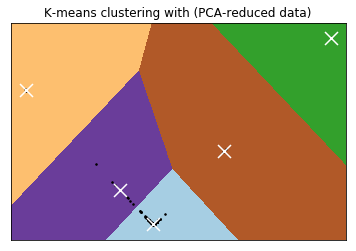

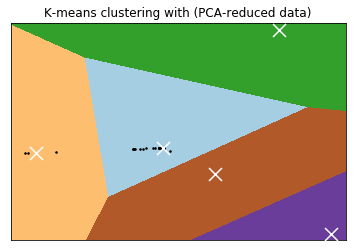

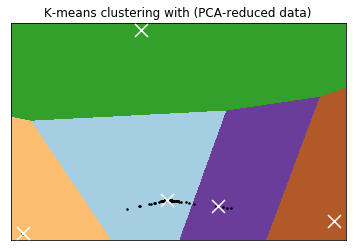

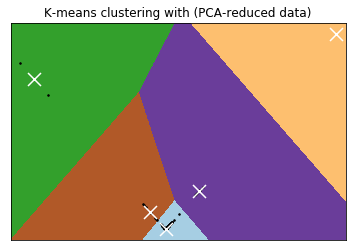

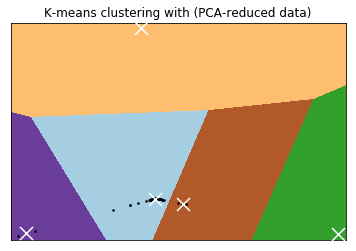

In [694]:
#Cluster all the samples and store them
centroids, features = read_centroid_features(centroid_filename, features_filename)
for i, train_df in enumerate(train_dfs):
    clustered_df = kmeans_clustering(train_df, centroids)
    clustered_df.to_csv(os.path.join(cluster_train_path,str(i+1)))
for i, test_df in enumerate(test_dfs): 
    clustered_df = kmeans_clustering(test_df, centroids)
    clustered_df.to_csv(os.path.join(cluster_test_path,str(i+1)))    

In [603]:
print(centroids)

[[ -0.04738068  -0.06822557  -0.06982052]
 [ 22.80308191  17.74949208  17.96797293]
 [ -0.04922785   6.2419703    7.16864891]
 [ -0.04223703   3.52101055  -0.09143534]
 [ -0.04922785  -0.12620575   4.4876168 ]]


In [697]:
def ge_clustering_results(cluster_path):
    files = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for file in files:
        if first:
            df = pd.read_csv(file, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(file, index_col=0)
            df = df.append(temp_df) 
    df = df.reset_index().set_index(['ip'])
    
    #Merge the duplicates
    new_columns =  ['cluster', 'packet_count']
    features = list(df.columns[:-1])
    cluster_column = list(df.columns[-1:])
    #Average packet count across all the samples
    packet_count = df[features].groupby('ip').mean().sum(axis=1).astype('int64')
    #most occuring cluster across all samples
    cluster = df[cluster_column].groupby('ip').median().astype('int64')
    #Create new dataframe with cluster and packet count 
    new_df = pd.concat([cluster, packet_count], axis=1)
    new_df.columns = new_columns
    return new_df

In [698]:
train_df = ge_clustering_results(train_cluster_path)
test_df = ge_clustering_results(test_cluster_path)

In [699]:
train_df.shape, test_df.shape

((1734, 2), (1495, 2))

In [700]:
#Save train result to file
train_tag_filename = 'ip_cluster_tag_train'
tag_file = os.path.join(base_path,train_tag_filename)
train_df.to_csv(tag_file)
#Save test result to file
test_tag_filename = 'ip_cluster_tag_test'
tag_file = os.path.join(base_path,test_tag_filename)
test_df.to_csv(tag_file)

In [701]:
train_tag_filename = 'ip_cluster_tag_train'
train_tag_file = os.path.join(base_path,train_tag_filename)
train_df = df.from_csv(train_tag_file)
test_tag_filename = 'ip_cluster_tag_test'
test_tag_file = os.path.join(base_path,test_tag_filename)
test_df = df.from_csv(test_tag_file)

In [702]:
import numpy as np
from scipy.misc import comb

def get_rand_index_score(train_df, test_df):
    r = pd.merge(train_df, test_df, left_index=True, right_index=True, how='right')
    r = r.dropna()
    r = r.astype(int)
    actual_clusters = r.iloc[:,0].tolist()
    predicted_clusters = r.iloc[:,1].tolist()    
    
    tp_plus_fp = comb(np.bincount(actual_clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(predicted_clusters), 2).sum()
    A = np.c_[(actual_clusters, predicted_clusters)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(actual_clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    ri =  (tp + tn) / (tp + fp + fn + tn)
    return ri

In [703]:
rand_index_score(actual_clusters, predicted_clusters)

0.99472997110442285

## Clustering the data captures during attack

In [713]:
attack_sample_dir_name = 'attack_samp'
attack_sample_path = os.path.join(base_path, attack_sample_dir_name)
attack_sample_train_path = os.path.join(base_path, attack_sample_dir_name+'_train')
os.makedirs(attack_sample_train_path, exist_ok=True)
attack_cluster_path = os.path.join(attack_sample_train_path, 'cluster')
os.makedirs(attack_cluster_path, exist_ok=True)

In [714]:
files = sorted(glob.glob(os.path.join(attack_sample_path,'*')),  key=os.path.getmtime)
merge_count = np.genfromtxt(os.path.join(base_path,'merge_count'))

In [715]:
files

['converted/test3/attack_samp/1',
 'converted/test3/attack_samp/2',
 'converted/test3/attack_samp/3',
 'converted/test3/attack_samp/4',
 'converted/test3/attack_samp/5',
 'converted/test3/attack_samp/6',
 'converted/test3/attack_samp/7',
 'converted/test3/attack_samp/8']

In [716]:
int(merge_count)

6

In [740]:
centroids, features = read_centroid_features(centroid_filename, features_filename)

In [745]:
attack_dfs = merge_files(files, merge_count, features)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


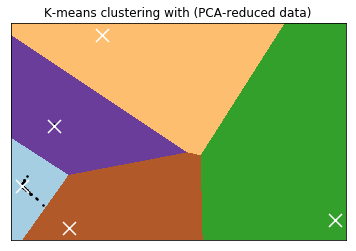

In [746]:
#Cluster all the samples and store them
centroids, features = read_centroid_features(centroid_filename, features_filename)
for i, attack_df in enumerate(attack_dfs):
    clustered_df = kmeans_clustering(attack_df, centroids)
    clustered_df.to_csv(os.path.join(attack_cluster_path,str(i+1)))

In [747]:
files = sorted(glob.glob(os.path.join(attack_cluster_path,'*')),  key=os.path.getmtime)
df = pd.read_csv(files[0], index_col=0)

In [750]:
train_tag_filename = 'ip_cluster_tag_train'
train_tag_file = os.path.join(base_path,train_tag_filename)
train_df = df.from_csv(train_tag_file)

In [749]:
df.head()

,1,6,17,cluster
ip,,,,
1.22.16.143,0,4,0,0
101.0.32.121,0,6,0,0
109.200.239.148,0,4,0,0
109.200.240.44,0,2,0,0
111.253.202.95,0,12,0,0


In [ ]:
for index, row in df.iterrows():
    print(row['cluster'])
    #Compare each ip data with the train cluster 
    # 1. Check if cluster is same then check if its inside the boundry usinf one class svm